# Leaky Integrate And Fire Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import poisson
from typing import List, Tuple

In [2]:
# https://github.com/neural-reckoning/cosyne-tutorial-2022/blob/main/1-lif.ipynb

# https://github.com/markstrefford/Spiking-Neural-Network/blob/master/SNN_0.ipynb

# https://github.com/arnaublanco/Integrate-and-Fire-model/blob/main/Integrate-and-fire%20model.ipynb

## Neuron Model

In [3]:
class Neuron:
    def __init__(self, v_rest, h, thr, tf, t_ref, lmbda):
        self.v_rest = v_rest
        self.h = h
        self.thr = thr
        self.tf = tf
        self.t_ref = t_ref
        self.lmbda = lmbda
        self.length_v = int(tf / h)
        self.t_ref_i = int(t_ref / h)
        self.v_values = np.zeros(self.length_v)

    def f(self, t, v):
        I_0 = 0.01
        R = 10**4
        tau = 0.02
        dv_dt = (-(v-self.v_rest)+R*I_0)/tau
        return dv_dt

    def euler(self, y0, t0):
        y_values = []
        t = t0
        y = y0
        while y < self.thr:
            t += self.h
            y += self.h * self.f(t, y)
            y_values.append(y)
        return y_values, t

    def simulate(self):
        i = 0
        t = 0
        step = 0
        while i < self.length_v:
            rnd_thr = random.random()
            prob = poisson.cdf(step, mu=self.lmbda)
            step += 1
            if prob < rnd_thr:
                rnd_time = int(self.t_ref_i * 4 * random.random())
                if i + rnd_time < self.length_v:
                    self.v_values[i:i+rnd_time] = self.v_rest
                    i = i + rnd_time
                    t = i * self.h
                else:
                    self.v_values[i:self.length_v] = self.v_rest
                    break
            else:
                v_t, t = self.euler(self.v_rest, t)
                new_i = int(round(t / self.h))
                if new_i + self.t_ref_i + 2 <= self.length_v:
                    self.v_values[i:new_i] = v_t
                    i = new_i + 1
                    self.v_values[i] = self.v_values[i-1] + 80
                    i += 1
                    self.v_values[i] = self.v_rest - 10
                    i += 1
                    new_i = i + self.t_ref_i
                    self.v_values[i:new_i] = self.v_rest
                    i = new_i
                    t = i * self.h
                else:
                    self.v_values[i:self.length_v] = self.v_rest
                    break
        return self.v_values


## Grid

In [4]:
class Grid:
    def __init__(self, size=9, random_state=None) -> None:
        self.random_state = random_state
        self.width = size
        self.height = size
        self.neurons_dict = {}
        self.electrode_dict = {}
        self.grid = [[None for _ in range(self.width)] for _ in range(self.height)]
        if self.random_state is not None:
            random.seed(self.random_state)

    def __place_neuron(self, row, col) -> None:
        self.grid[row][col] = "Neuron"

    def __place_electrode(self, empty_grid: List[List], row, col) -> Tuple[int]:
        if empty_grid[row][col] == "Neuron" or empty_grid[row][col] == "Electrode":
            self.__place_electrode(empty_grid)
        else:
            empty_grid[row][col] = "Electrode"
            return row, col
        
    def __calculate_distances(self, x, y):
        """Distance to Neuron"""
        distances = []
        for neuron in self.neurons_dict.keys():
            neuron_x, neuron_y = self.neurons_dict[neuron]["row"], self.neurons_dict[neuron]["col"]
            distances.append(np.sqrt((x - neuron_x)**2 + (y - neuron_y)**2))
        return distances
        
    def __decay_mulitplier(self, distance: float, k: int=1, type: str="inverse") -> int:
        if type == "linear":
            return max(0, k - distance)
        elif type == "exponential":
            return np.exp(-k * distance)
        elif type == "square":
            return k /( distance ** 2)
        elif type == "inverse":
            if distance != 0:
                return k / distance
            else:
                return np.inf
        else:
            raise ValueError(f"Unknown decay type: {type}")
        
    def noise(self, signal, noise_stddev=0.5):
        noise = np.random.normal(0, noise_stddev, signal.shape)
        return noise

    def add_neurons(self, positions: List[Tuple]=False):
        if positions:
            for i, position in enumerate(positions):
                try:
                    row, col = position[0], position[1]
                    self.__place_neuron(row, col)
                    self.neurons_dict[i] = {"row": row, "col": col, "object": Neuron(v_rest=-70, h=0.001, thr=-40, tf=1, t_ref=0.02, lmbda=14)}
                except:
                    print("Something went wrong placing your neurons")
        else:
            row, col = self.width // 2, self.height // 2
            self.__place_neuron(row, col)
            self.neurons_dict[0] = {"row": row, "col": col, "object": Neuron(v_rest=-70, h=0.001, thr=-40, tf=1, t_ref=0.02, lmbda=14)}

    def add_electrodes(self, positions: List[Tuple]=False):
        if positions:
            for i, position in enumerate(positions):
                try:
                    row, col = position[0], position[1]

                    # if something already exist at this grid position, give a warning
                    if self.grid[row][col]:
                        print(f"WARNING... There is already a {self.grid[row][col]} at ({row},{col})" )

                    self.__place_electrode(self.grid, row, col)
                    self.electrode_dict[i] = { "row": row, "col": col, "distances": self.__calculate_distances(row, col), "signals": [] }
                except:
                    print("Something went wrong placing your neurons")
        else:
            for i in range(3):
                row, col = random.randint(0, self.width - 1), random.randint(0, self.height - 1)
                self.electrode_dict[i] = { "row": row, "col": col, "distances": self.__calculate_distances(row, col), "signals": [] }
                self.__place_electrode(self.grid, row, col)

    def generate_signals(self):
        if len(self.neurons_dict.keys()) == 0 or len(self.electrode_dict.keys()) == 0:
            raise ValueError("You need both Neurons and Electrodes to record signals")
        
        # stimulate each of the neurons to produce a signal
        for neuron in self.neurons_dict.keys():
            neuron_signal = self.neurons_dict[neuron]["object"].simulate()
            self.neurons_dict[neuron]["signal"] = neuron_signal

            # each electrode records this signal with its intensity depending on the distance from the neuron
            for electrode in self.electrode_dict.keys():
                distance = self.electrode_dict[electrode]["distances"][neuron]
                decay = self.__decay_mulitplier(distance=distance, k=2, type="square")
                # print("Neuron:", neuron , "Electrode:", electrode, "Distance:", distance)
                self.electrode_dict[electrode]["signals"].append((neuron_signal * decay) + self.noise(neuron_signal))
        
        # combine the signals of all of the neurons and combine them (only neccesary if more than one neuron exists)
        if len(list(self.neurons_dict.keys())) > 0:
            for electrode in self.electrode_dict.keys():
                combined_signal = np.zeros_like(self.electrode_dict[electrode]["signals"][0])
                for neuron in self.neurons_dict.keys():
                    combined_signal += self.electrode_dict[electrode]["signals"][neuron]

                self.electrode_dict[electrode]["signal"] = combined_signal

    def plot_grid(self) -> None:
        plt.figure(figsize=(6,6))
        
        # extract neuron and electrode positions
        neuron_positions = [(v["row"], v["col"]) for v in self.neurons_dict.values()]
        electrode_positions = [(v["row"], v["col"]) for v in self.electrode_dict.values()]

        # if there are neurons, plot them
        if neuron_positions:
            neuron_rows, neuron_cols = zip(*neuron_positions) # unzip into x and y coordinates
            plt.scatter(neuron_rows, neuron_cols, color='r', label='Neurons', s=100)

        # if there are electrodes, plot them
        if electrode_positions:
            electrode_rows, electrode_cols = zip(*electrode_positions) # unzip into x and y coordinates
            plt.scatter(electrode_rows, electrode_cols, color='b', label='Electrodes', s=100)

        plt.xlim(0, self.width - 1)
        plt.ylim(0, self.height - 1)
        plt.grid(True)
        plt.legend()
        plt.title("Grid with Neurons and Electrodes")
        plt.show()

In [5]:
grid = Grid()

# add neurons to the grid -> if no coordinates specified, a single neuron will be placed at the center
# grid.add_neurons()
grid.add_neurons([(1, 1), (5, 6)])

# add electrodes to the grid -> if no coordinates specified, three electrode will be randomly placed
# grid.add_electrodes()
grid.add_electrodes([(1, 3), (4, 7), (4, 2), (7, 2)])

# stimulate the neurons and record their emitted signals
grid.generate_signals()

The position of the neurons and electrodes can be visualised

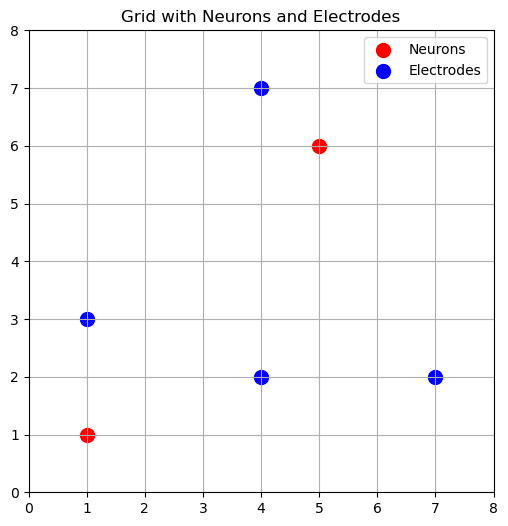

In [6]:
grid.plot_grid()

We can show how the emitted signal from each neuron is being recorded by each electrode with attenuation noise.

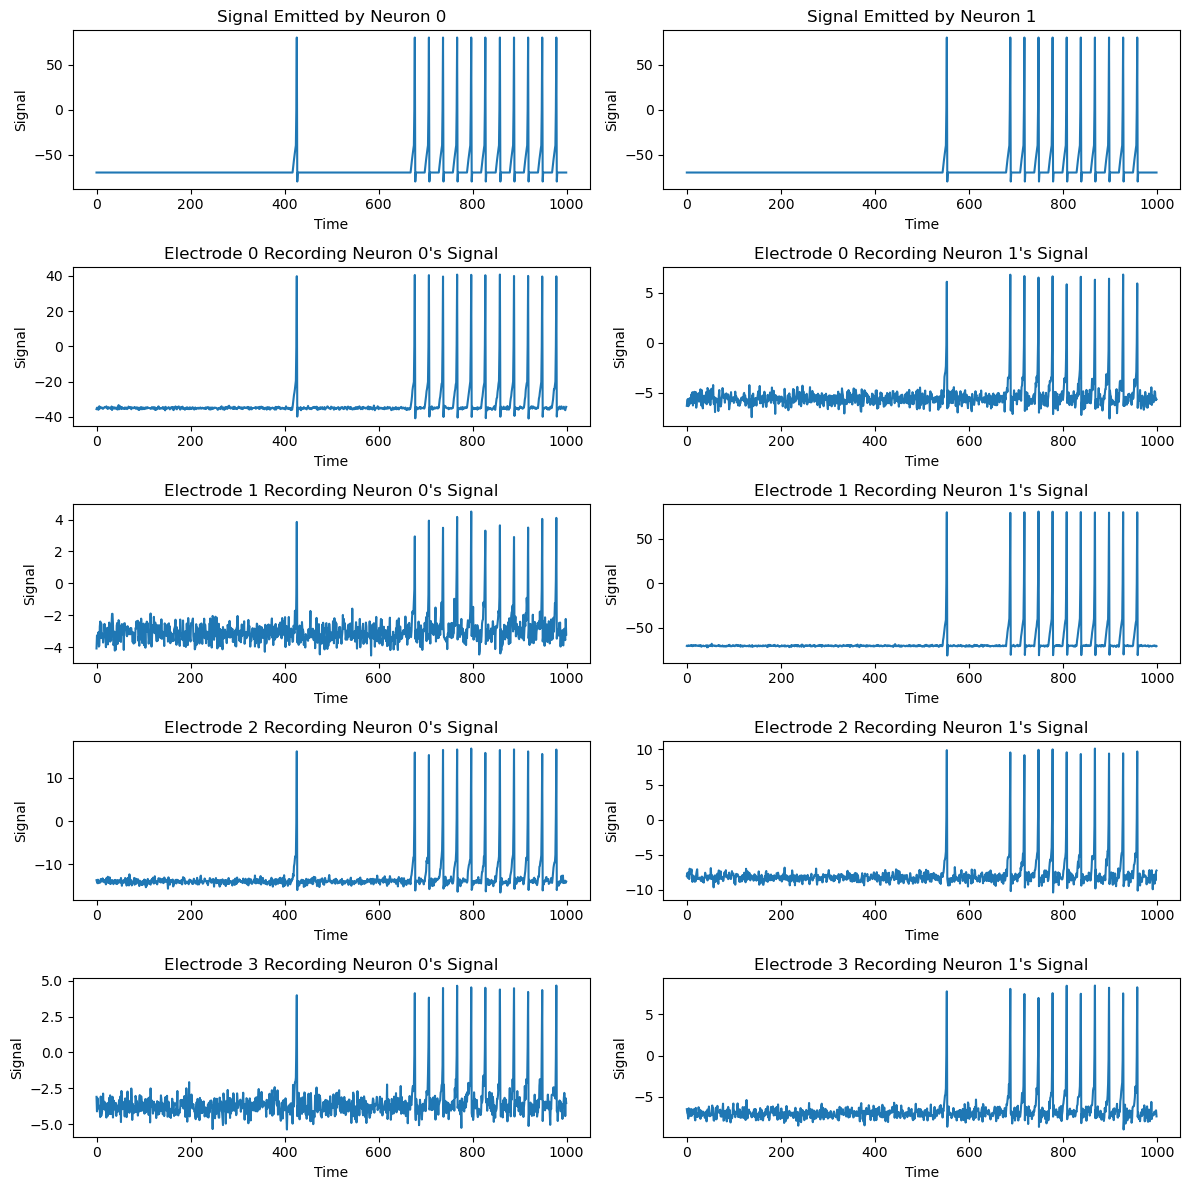

In [7]:
def plot_signals(grid, neuron_ids, electrode_ids):
    # If neuron_ids is a single value, convert it to a list
    if not isinstance(neuron_ids, list):
        neuron_ids = [neuron_ids]

    # Create a figure with one subplot for each neuron and electrode
    fig, axs = plt.subplots(len(electrode_ids) + 1, len(neuron_ids), figsize=(12, 12))

    # Handle the case where there's only one neuron and multiple electrodes
    if len(neuron_ids) == 1 and len(electrode_ids) > 1:
        axs = np.expand_dims(axs, axis=1)

    # Plot the original signals from the neurons
    for ax, neuron_id in zip(axs[0], neuron_ids):
        neuron_signal = grid.neurons_dict[neuron_id]["signal"]
        time = np.arange(len(neuron_signal))
        ax.plot(time, neuron_signal)
        ax.set_title(f'Signal Emitted by Neuron {neuron_id}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Signal')

    # Plot the recorded signals from the electrodes
    for i, electrode_id in enumerate(electrode_ids, start=1):
        for j, ax in enumerate(axs[i]):
            electrode_signal = grid.electrode_dict[electrode_id]["signals"][neuron_ids[j]]
            time = np.arange(len(electrode_signal))
            ax.plot(time, electrode_signal)
            ax.set_title(f"Electrode {electrode_id} Recording Neuron {j}'s Signal")
            ax.set_xlabel('Time')
            ax.set_ylabel('Signal')

    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.show()

plot_signals(grid=grid, neuron_ids=list(grid.neurons_dict.keys()), electrode_ids=list(grid.electrode_dict.keys()))

The signals recorded by each electrode should be a combination of the neurons signals.

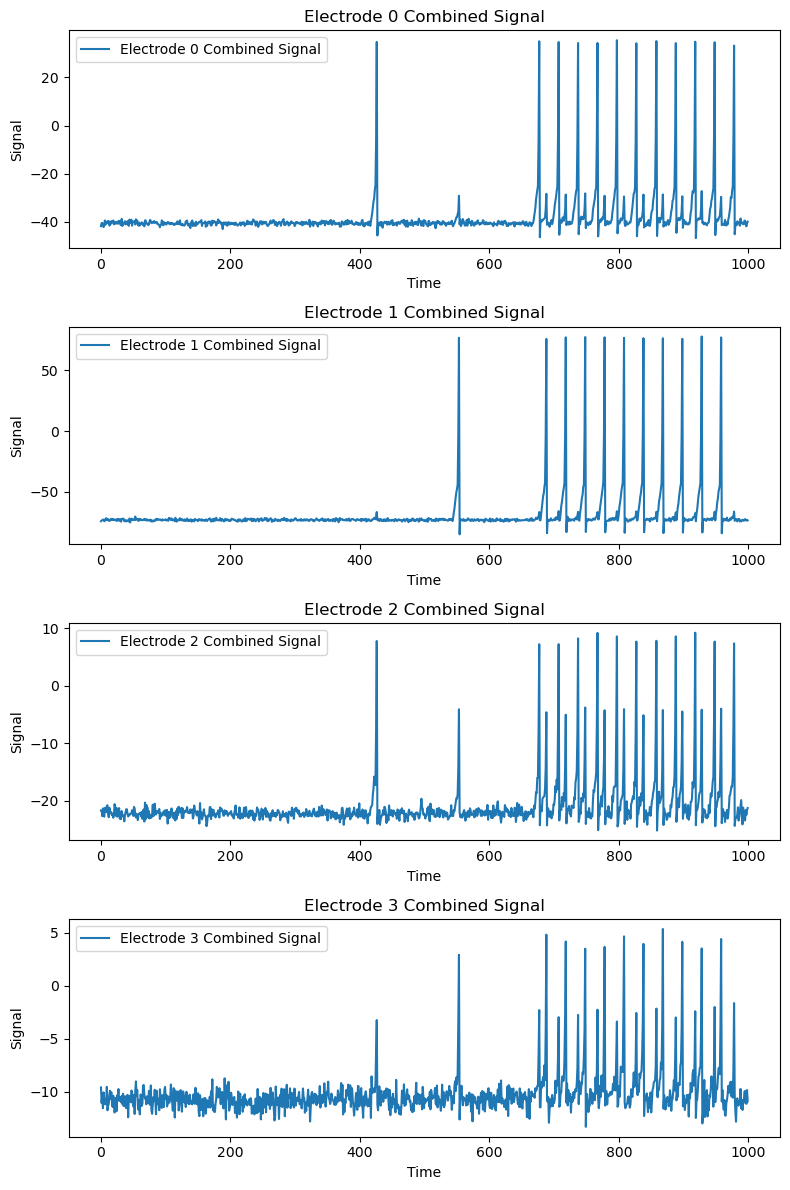

In [8]:
import matplotlib.pyplot as plt

def plot_combined_signals(grid, electrode_ids):
    # Create a figure with one subplot for each electrode
    fig, axs = plt.subplots(len(electrode_ids), 1, figsize=(8, 12))

    # Handle the case where there's only one electrode
    if len(electrode_ids) == 1:
        axs = [axs]

    # Plot the combined signals from the electrodes
    for electrode_id, ax in enumerate(axs):
        # Get the combined signal
        combined_signal = grid.electrode_dict[electrode_id]["signal"]

        # Plot the combined signal
        time = np.arange(len(combined_signal))
        ax.plot(time, combined_signal, label=f'Electrode {electrode_id} Combined Signal')
        ax.set_title(f'Electrode {electrode_id} Combined Signal')
        ax.set_xlabel('Time')
        ax.set_ylabel('Signal')
        ax.legend()

    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.show()


plot_combined_signals(grid=grid, electrode_ids=list(grid.electrode_dict.keys()))